## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import RobertaTokenizer
import transformers

from text_data import TextDataset4 as TextDataset
from roberta import CustomRoberta2 as CustomRoberta
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr, SCELoss
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv')
train = pd.read_csv(f'{path}train.csv')

In [3]:
%%time
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
sep_token = f' {tokenizer.sep_token} '
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    ids, seg_ids, sent_ids = [], [], []
    for x1, x2, x3 in tqdm(df[['question_title', 'question_body', 'answer']].values):
        encoded_inputs = tokenizer.encode_plus(
            x1 + sep_token + x2, x3, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
            return_token_type_ids=True
        )
        inp_ids = encoded_inputs['input_ids']
        raw_seg_ids = np.array(encoded_inputs['token_type_ids'])
        qa_split_idx = np.where(np.array(inp_ids) == tokenizer.sep_token_id)[0][0] + 1
        raw_seg_ids[qa_split_idx:] += 1
        raw_seg_ids = (raw_seg_ids * (np.array(inp_ids) != tokenizer.pad_token_id).astype(int)).tolist()
        
        ids.append(inp_ids)
        seg_ids.append(raw_seg_ids)
    if mode == 'train': 
        ids_train = np.array(ids)
        seg_ids_train = np.array(seg_ids)
    else: 
        ids_test = np.array(ids)
        seg_ids_test = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 15.2 s, sys: 79.4 ms, total: 15.3 s
Wall time: 16.1 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

In [8]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test, seg_ids_test, test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [9]:
lr = 0.001
loss_fn = SCELoss()#nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4

weight_decay = 0.01
model_name = 'siamese_roberta_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [10]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.roberta, lr / 100, weight_decay)
    )

Fold 1 started at Sat Feb  8 12:04:09 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


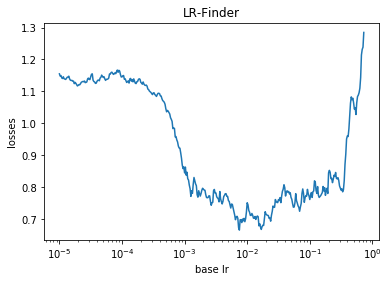

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74468 - spearmanr 0.15706
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.62448 - spearmanr 0.3278


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.3278
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59736 - spearmanr 0.34482
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.59297 - spearmanr 0.38445
best model: epoch 1 - 0.38445
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.56105 - spearmanr 0.41043
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.57615 - spearmanr 0.39743
best model: epoch 2 - 0.39743
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53715 - spearmanr 0.45008
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.57267 - spearmanr 0.40536
best model: epoch 3 - 0.40536
TRAINING END: Best score achieved on epoch 3 - 0.40536
Starting inference for model: checkpoints/siamese_roberta_2_fold_1_best.pth



Averaged Val. score: 0.40535830071101386
Starting inference for model: checkpoints/siamese_roberta_2_fold_1_best.pth



Fold 2 started at Sat Feb  8 12:26:23 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74151 - spearmanr 0.17017
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.62474 - spearmanr 0.33938
best model: epoch 0 - 0.33938
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59276 - spearmanr 0.35202
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.59839 - spearmanr 0.38567
best model: epoch 1 - 0.38567
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55848 - spearmanr 0.41375
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.57913 - spearmanr 0.41061
best model: epoch 2 - 0.41061
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53562 - spearmanr 0.45148
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.5782 - spearmanr 0.41084
best model: epoch 3 - 0.41084
TRAINING END: Best score achieved on epoch 3 - 0.41084
Starting inference for model: checkpoints/siamese_roberta_2_fold_2_best.pth



Averaged Val. score: 0.41084366560821356
Starting inference for model: checkpoints/siamese_roberta_2_fold_2_best.pth



Fold 3 started at Sat Feb  8 12:47:42 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.7385 - spearmanr 0.16609
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.61721 - spearmanr 0.32941
best model: epoch 0 - 0.32941
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59379 - spearmanr 0.35473
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.59522 - spearmanr 0.371
best model: epoch 1 - 0.371
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55647 - spearmanr 0.41626
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.58785 - spearmanr 0.39219
best model: epoch 2 - 0.39219
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53415 - spearmanr 0.45424
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.5838 - spearmanr 0.39314
best model: epoch 3 - 0.39314
TRAINING END: Best score achieved on epoch 3 - 0.39314
Starting inference for model: checkpoints/siamese_roberta_2_fold_3_best.pth



Averaged Val. score: 0.39313618282878465
Starting inference for model: checkpoints/siamese_roberta_2_fold_3_best.pth



Fold 4 started at Sat Feb  8 13:08:40 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74966 - spearmanr 0.15573
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.63052 - spearmanr 0.31392
best model: epoch 0 - 0.31392
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59662 - spearmanr 0.34843
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.59408 - spearmanr 0.36355
best model: epoch 1 - 0.36355
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55925 - spearmanr 0.41322
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.58129 - spearmanr 0.3853
best model: epoch 2 - 0.3853
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.5363 - spearmanr 0.4517
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.58259 - spearmanr 0.3832
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.38530
Starting inference for model: checkpoints/siamese_roberta_2_fold_4_best.pth



Averaged Val. score: 0.3852993942485329
Starting inference for model: checkpoints/siamese_roberta_2_fold_4_best.pth



Fold 5 started at Sat Feb  8 13:29:36 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74584 - spearmanr 0.15202
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.62053 - spearmanr 0.32849
best model: epoch 0 - 0.32849
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59579 - spearmanr 0.35249
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.58302 - spearmanr 0.37573
best model: epoch 1 - 0.37573
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55906 - spearmanr 0.41509
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.57229 - spearmanr 0.38564
best model: epoch 2 - 0.38564
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53597 - spearmanr 0.45415
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.57177 - spearmanr 0.39102
best model: epoch 3 - 0.39102
TRAINING END: Best score achieved on epoch 3 - 0.39102
Starting inference for model: checkpoints/siamese_roberta_2_fold_5_best.pth



Averaged Val. score: 0.39102337567964107
Starting inference for model: checkpoints/siamese_roberta_2_fold_5_best.pth



Fold 6 started at Sat Feb  8 13:50:51 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74048 - spearmanr 0.16869
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.61032 - spearmanr 0.32578
best model: epoch 0 - 0.32578
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59566 - spearmanr 0.35297
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.58257 - spearmanr 0.37191
best model: epoch 1 - 0.37191
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55978 - spearmanr 0.41428
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.57329 - spearmanr 0.38292
best model: epoch 2 - 0.38292
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53651 - spearmanr 0.45335
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.57102 - spearmanr 0.38856
best model: epoch 3 - 0.38856
TRAINING END: Best score achieved on epoch 3 - 0.38856
Starting inference for model: checkpoints/siamese_roberta_2_fold_6_best.pth



Averaged Val. score: 0.38855511626422556
Starting inference for model: checkpoints/siamese_roberta_2_fold_6_best.pth



Fold 7 started at Sat Feb  8 14:12:32 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.73956 - spearmanr 0.16518
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.63105 - spearmanr 0.32095
best model: epoch 0 - 0.32095
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59557 - spearmanr 0.34883
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.59923 - spearmanr 0.37957
best model: epoch 1 - 0.37957
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.5598 - spearmanr 0.41028
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.5914 - spearmanr 0.39316
best model: epoch 2 - 0.39316
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53596 - spearmanr 0.44988
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.58536 - spearmanr 0.4
best model: epoch 3 - 0.4
TRAINING END: Best score achieved on epoch 3 - 0.40000
Starting inference for model: checkpoints/siamese_roberta_2_fold_7_best.pth



Averaged Val. score: 0.40000193034500864
Starting inference for model: checkpoints/siamese_roberta_2_fold_7_best.pth



Fold 8 started at Sat Feb  8 14:33:45 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.73684 - spearmanr 0.16875
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.62734 - spearmanr 0.33854
best model: epoch 0 - 0.33854
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59634 - spearmanr 0.3461
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.58492 - spearmanr 0.39048
best model: epoch 1 - 0.39048
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55948 - spearmanr 0.40997
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.58077 - spearmanr 0.40505
best model: epoch 2 - 0.40505
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.536 - spearmanr 0.44974
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.57849 - spearmanr 0.40667
best model: epoch 3 - 0.40667
TRAINING END: Best score achieved on epoch 3 - 0.40667
Starting inference for model: checkpoints/siamese_roberta_2_fold_8_best.pth



Averaged Val. score: 0.40667213448650236
Starting inference for model: checkpoints/siamese_roberta_2_fold_8_best.pth



Fold 9 started at Sat Feb  8 14:55:03 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74413 - spearmanr 0.16617
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.60382 - spearmanr 0.32926
best model: epoch 0 - 0.32926
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59307 - spearmanr 0.35702
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.58094 - spearmanr 0.37198
best model: epoch 1 - 0.37198
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.55798 - spearmanr 0.41633
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.57206 - spearmanr 0.38167
best model: epoch 2 - 0.38167
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53507 - spearmanr 0.45492
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.57018 - spearmanr 0.38573
best model: epoch 3 - 0.38573
TRAINING END: Best score achieved on epoch 3 - 0.38573
Starting inference for model: checkpoints/siamese_roberta_2_fold_9_best.pth



Averaged Val. score: 0.385725863070417
Starting inference for model: checkpoints/siamese_roberta_2_fold_9_best.pth



Fold 10 started at Sat Feb  8 15:16:21 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.74623 - spearmanr 0.15989
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.61239 - spearmanr 0.3387
best model: epoch 0 - 0.3387
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.59732 - spearmanr 0.34953
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.5765 - spearmanr 0.39835
best model: epoch 1 - 0.39835
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.56073 - spearmanr 0.41156
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.56751 - spearmanr 0.40789
best model: epoch 2 - 0.40789
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.53729 - spearmanr 0.45186
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.56328 - spearmanr 0.4092
best model: epoch 3 - 0.4092
TRAINING END: Best score achieved on epoch 3 - 0.40920
Starting inference for model: checkpoints/siamese_roberta_2_fold_10_best.pth



Averaged Val. score: 0.4092001073910475
Starting inference for model: checkpoints/siamese_roberta_2_fold_10_best.pth



OOF score: 0.39831712163310157


In [11]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train, seg_ids_train, train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train, seg_ids_train, valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomRoberta(cat_features_train.shape[1])
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [12]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 16 0.4943158675373773
5 8 0.4712235055110494
7 4 0.5084195946303567
11 32 0.731588594756703
12 4 0.5474706434510769
13 16 0.2570660634047377
14 16 0.6429011445667521
15 8 0.5964727628002172
16 16 0.7855631581649605
26 16 0.7478822122284372


In [13]:
np.array(opt_ds), np.array(opt_indices)

(array([16,  8,  4, 32,  4, 16, 16,  8, 16, 16]),
 array([ 2,  5,  7, 11, 12, 13, 14, 15, 16, 26]))

In [14]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [15]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.398317
CV unique rows,0.358335
CV ignoring hard targets,0.421212
CV unique rows ignoring hard targets,0.378551
CV w rounding,0.426286
CV unique rows w rounding,0.398836
CV ignoring hard targets w rounding,0.451178
CV unique rows ignoring hard targets w rounding,0.421945


In [16]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.402243
CV unique rows,0.362432
CV ignoring hard targets,0.421212
CV unique rows ignoring hard targets,0.378551
CV w rounding,0.430211
CV unique rows w rounding,0.402933
CV ignoring hard targets w rounding,0.451178
CV unique rows ignoring hard targets w rounding,0.421945


In [17]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [18]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.955995,0.530384,0.581000,0.326768,0.234749,0.174680,0.867107,0.902951,0.832414,0.001041,0.964741,0.960653,0.010546,0.381646,0.000925,0.000278,0.015246,0.038495,0.868641,0.000220,0.943187,0.813045,0.208530,0.942392,0.928119,0.369748,0.013493,0.016417,0.917508,0.873524
1,46,0.691045,0.205910,0.001700,0.824819,0.881636,0.964657,0.293764,0.121318,0.075136,0.001153,0.474254,0.604182,0.001441,0.000131,0.000131,0.002231,0.977101,0.193132,0.017872,0.000058,0.361103,0.899044,0.420049,0.947957,0.955382,0.559748,0.979251,0.119155,0.026819,0.660380
2,70,0.947522,0.839582,0.013076,0.915412,0.958261,0.975955,0.534570,0.283173,0.207059,0.000514,0.063865,0.916384,0.011770,0.032848,0.000186,0.001666,0.010256,0.028202,0.784592,0.000176,0.932441,0.952821,0.425805,0.968856,0.971510,0.837616,0.032556,0.033053,0.877053,0.786232
3,132,0.790181,0.102394,0.001737,0.843128,0.822615,0.952384,0.353734,0.137394,0.036961,0.005251,0.563185,0.004911,0.000186,0.000598,0.000129,0.001319,0.937459,0.071239,0.892841,0.000047,0.339675,0.897422,0.487726,0.959758,0.972796,0.675385,0.929971,0.065077,0.714690,0.733227
4,200,0.947314,0.209347,0.043584,0.808190,0.835698,0.837824,0.859136,0.873285,0.458314,0.002320,0.528925,0.939992,0.004219,0.014983,0.001153,0.010567,0.040100,0.111044,0.548045,0.000768,0.768411,0.801855,0.281812,0.938122,0.912389,0.454732,0.023103,0.049776,0.724887,0.878756


In [19]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [20]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.962551,0.788901,0.078211,0.672826,0.775364,0.300000,0.868357,0.494718,0.502467,0.000138,0.833934,0.012390,0.483811,0.009257,0.001533,0.106404,0.016865,0.012791,0.857119,0.000037,0.971581,0.974732,0.684999,0.989033,0.987826,0.896401,0.018099,0.029776,0.970314,0.963908
1,0.954509,0.819797,0.008062,0.561970,0.985792,0.712064,0.631012,0.846767,0.424508,0.000846,0.091055,0.006291,0.962487,0.001221,0.988913,0.008161,0.011853,0.027042,0.178486,0.002861,0.883058,0.834439,0.392065,0.927110,0.970268,0.484497,0.004884,0.006577,0.396679,0.907439
2,0.735936,0.154007,0.004823,0.884788,0.841309,0.943193,0.473751,0.107746,0.033405,0.001114,0.390057,0.307189,0.001613,0.001927,0.000423,0.044828,0.762409,0.070029,0.079893,0.000312,0.591114,0.974464,0.778702,0.972385,0.987261,0.951766,0.750247,0.115707,0.632466,0.923416
3,0.958054,0.885141,0.026447,0.935640,0.978453,0.978986,0.756154,0.827666,0.748951,0.000808,0.026421,0.991847,0.001822,0.007579,0.023973,0.038017,0.008413,0.122729,0.479956,0.004873,0.961928,0.965555,0.899373,0.979581,0.977592,0.922157,0.028741,0.090532,0.942878,0.917957
4,0.952846,0.967305,0.000567,0.878818,0.970091,0.987961,0.540935,0.276844,0.048148,0.000179,0.088763,0.592694,0.000203,0.000148,0.000056,0.001718,0.972876,0.133572,0.015587,0.000043,0.970333,0.935713,0.424336,0.958646,0.963837,0.714019,0.952505,0.146390,0.048489,0.836470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.972802,0.846152,0.029011,0.927747,0.882551,0.710399,0.813137,0.890381,0.371120,0.000449,0.451561,0.996810,0.007051,0.163421,0.005592,0.006866,0.007755,0.020364,0.364320,0.000391,0.971423,0.973739,0.835568,0.989434,0.982320,0.875960,0.018214,0.016561,0.963984,0.952767
6075,0.941351,0.257063,0.011022,0.623218,0.685333,0.418312,0.769502,0.541096,0.055768,0.000490,0.886968,0.018245,0.008864,0.000466,0.000102,0.017872,0.946526,0.168261,0.007804,0.000052,0.797312,0.964627,0.689762,0.982198,0.985039,0.747553,0.899588,0.112884,0.201724,0.945906
6076,0.754937,0.205833,0.001478,0.838034,0.859148,0.973036,0.269472,0.095585,0.201927,0.001654,0.415470,0.487154,0.000998,0.000367,0.000193,0.004635,0.982488,0.210915,0.071289,0.000075,0.309597,0.839271,0.275036,0.924279,0.939200,0.410498,0.969375,0.111121,0.073732,0.663402
6077,0.964962,0.520373,0.856562,0.197445,0.213477,0.059103,0.830059,0.919717,0.894514,0.001263,0.966135,0.801038,0.026428,0.020827,0.059642,0.002632,0.001412,0.032426,0.961831,0.000980,0.973099,0.857845,0.737764,0.928907,0.955386,0.481999,0.003519,0.018166,0.979391,0.918752


In [21]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.386036
question_body_critical                   0.605491
question_conversational                  0.409575
question_expect_short_answer             0.297275
question_fact_seeking                    0.355986
question_has_commonly_accepted_answer    0.425836
question_interestingness_others          0.368806
question_interestingness_self            0.504441
question_multi_intent                    0.532168
question_not_really_a_question           0.087448
question_opinion_seeking                 0.472826
question_type_choice                     0.718376
question_type_compare                    0.363098
question_type_consequence                0.190760
question_type_definition                 0.363499
question_type_entity                     0.445305
question_type_instructions               0.778042
question_type_procedure                  0.367331
question_type_reason_explanation         0.661085
question_type_spelling                   0.068143


In [22]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.068143,3.0
question_not_really_a_question,0.087448,5.0
answer_plausible,0.127761,9.0
answer_relevance,0.152591,9.0
answer_well_written,0.166109,9.0
question_type_consequence,0.190760,5.0
answer_helpful,0.207678,9.0
question_expect_short_answer,0.297275,5.0
answer_type_procedure,0.299626,5.0
answer_satisfaction,0.303568,17.0


In [23]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'answer_well_written'],
      dtype='object')

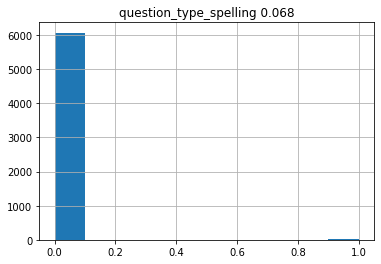

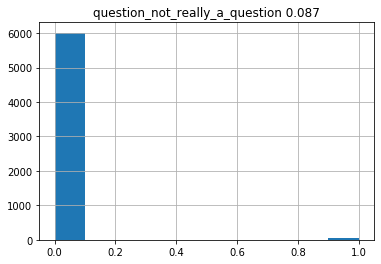

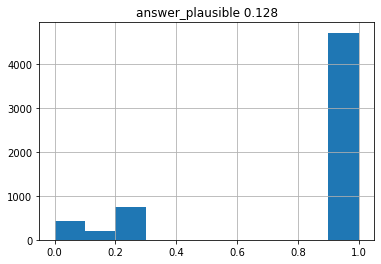

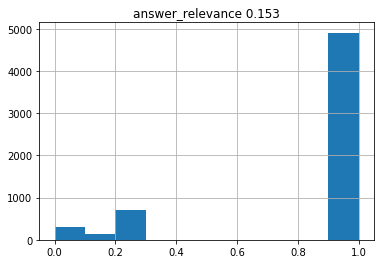

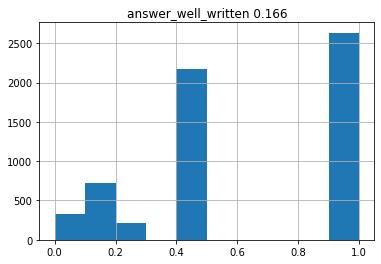

In [24]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


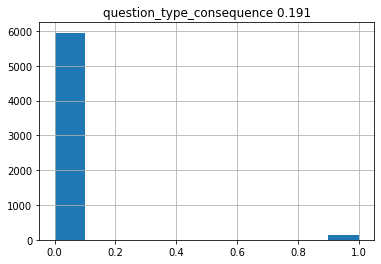

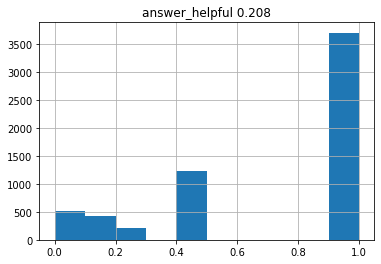

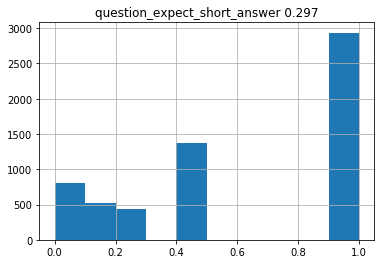

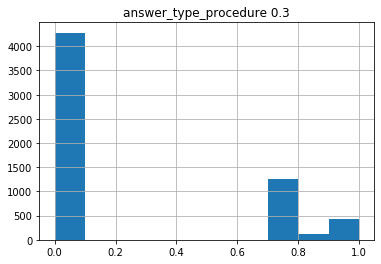

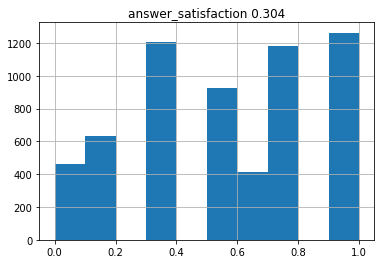

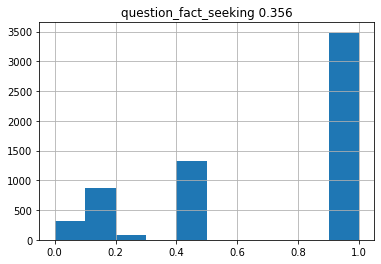

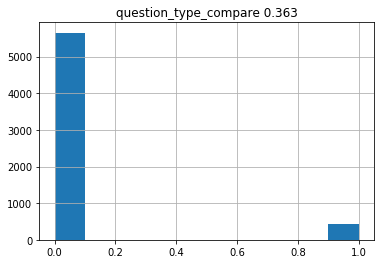

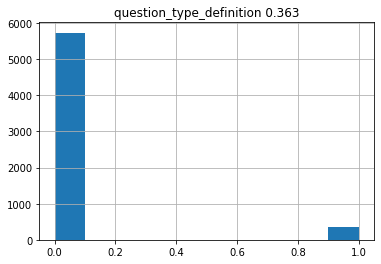

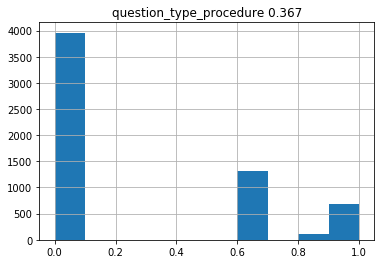

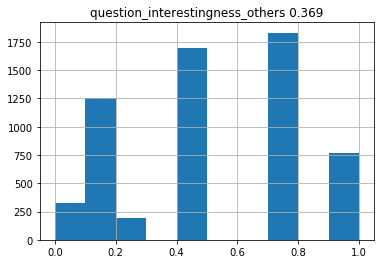

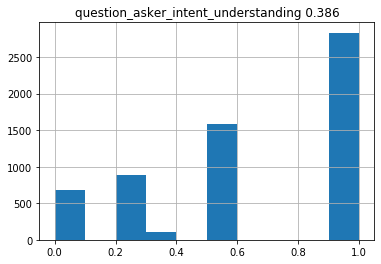

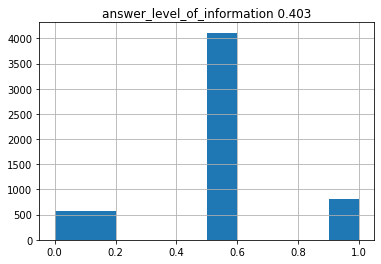

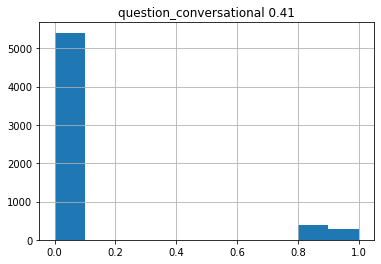

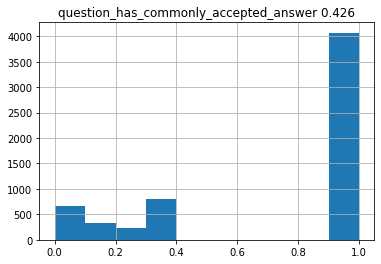

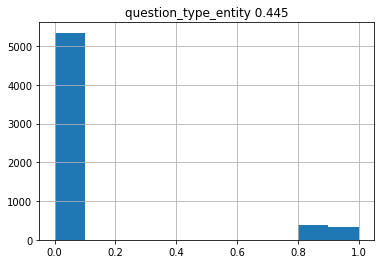

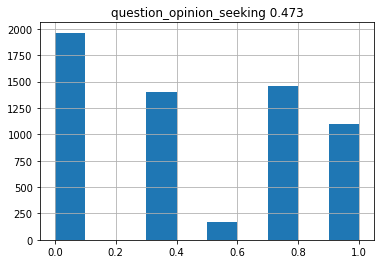

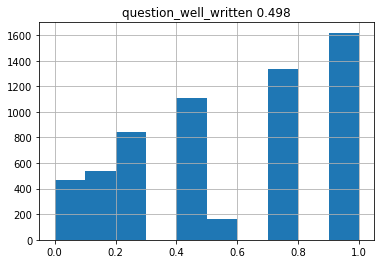

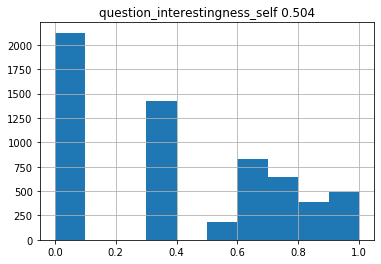

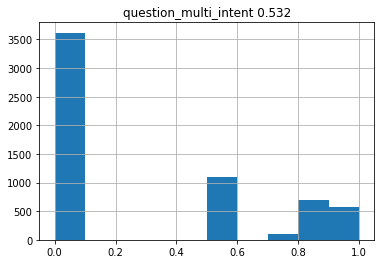

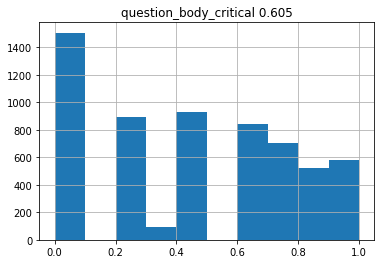

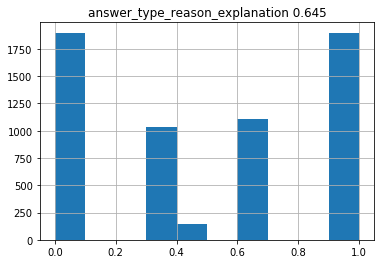

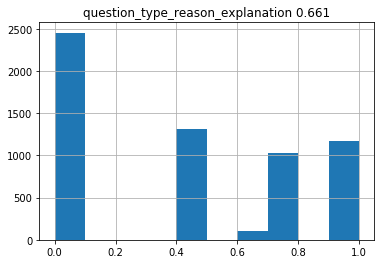

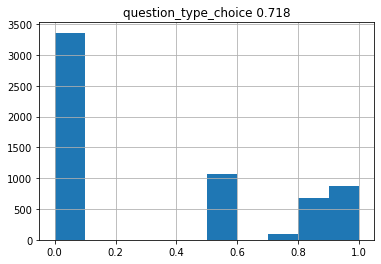

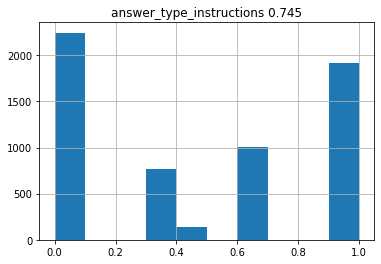

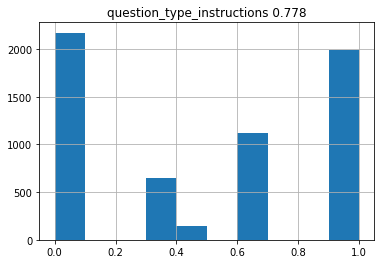

In [25]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

In [29]:
def load_model(checkpoint_file, model):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    model = CustomRoberta(cat_features_train.shape[1])
    load_model(checkpoint_file, model)
    return model

def save_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_half_fold_{fold_id+1}_best.pth'
    torch.save({'model_state_dict': model.state_dict()}, checkpoint_file)

In [30]:
for fold_id in range(n_folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    model = get_model(fold_id)
    model.half()
    save_model(model)

Fold 1 started at Sat Feb  8 20:34:12 2020
Fold 2 started at Sat Feb  8 20:34:17 2020
Fold 3 started at Sat Feb  8 20:34:21 2020
Fold 4 started at Sat Feb  8 20:34:26 2020
Fold 5 started at Sat Feb  8 20:34:31 2020
Fold 6 started at Sat Feb  8 20:34:35 2020
Fold 7 started at Sat Feb  8 20:34:40 2020
Fold 8 started at Sat Feb  8 20:34:44 2020
Fold 9 started at Sat Feb  8 20:34:48 2020
Fold 10 started at Sat Feb  8 20:34:52 2020
